# Vehicle Detection Pipeline

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
%matplotlib inline

## Load Images

The number of vehicles and non-vehicles is roughly the same. This will prevent overfitting to one particular class of images.

Number of Cars: 8792
Number of Non-cars: 8968


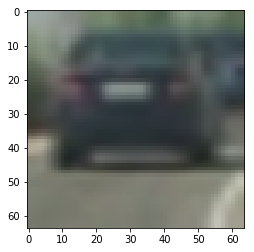

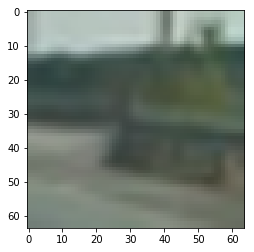

In [21]:
# Read in cars and notcars
gti_car_images = glob.glob('vehicles/GTI_*/*.png')
gti_notcar_images = glob.glob('non-vehicles/GTI/*.png')
cars = []
notcars = []
from random import randint
for i in range(0, len(gti_car_images)):
    cars.append(gti_car_images[i])
for i in range(0, len(gti_notcar_images)):
    notcars.append(gti_notcar_images[i])
        
extra_car_images = glob.glob('vehicles/KITTI_extracted/*.png')
extra_notcar_images = glob.glob('non-vehicles/Extras/*.png')
for img in extra_car_images:
    cars.append(img)
for img in extra_notcar_images:
    notcars.append(img)

print('Number of Cars:', len(cars))
print('Number of Non-cars:', len(notcars))

carimg = mpimg.imread(cars[1])
plt.imshow(carimg)
plt.show()
notcarimg = mpimg.imread(notcars[1])
plt.imshow(notcarimg)
plt.show()

## Set Parameters

In [14]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
frame_count = 30 # Number of previous frames to track
scales = [((400, 600), 1), # Scales and corresponding windows to search
          ((400, 600), 1.5)]

## Extract Features and Apply Scaling

Spatial, color, and HOG features are extracted for each of the training images. The features are combined and scaled for normalization.

Below is shown an example of the HOG features on a training image.

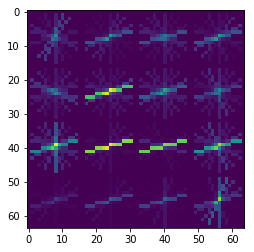

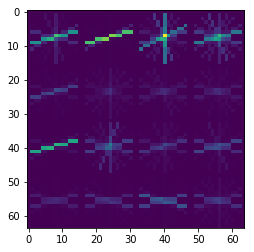

In [23]:
def show_hog_vis(img):
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    features, hog_image = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    plt.imshow(hog_image)
    plt.show()

show_hog_vis(carimg)
show_hog_vis(notcarimg)

In [4]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

scaled_X, y = shuffle(scaled_X, y)

/Users/victorkai/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Train Classifier

In [5]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1788
8.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


## Sliding Windows

Below are visualizations of the windows in the image we will search at various scales.

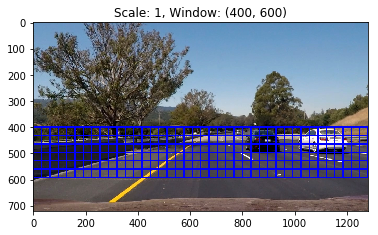

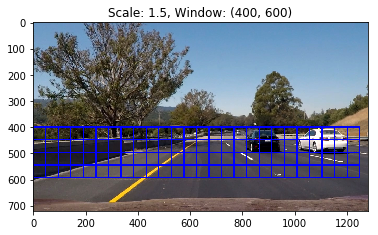

In [34]:
image = mpimg.imread('test_images/test6.jpg')

for scale in scales:
    draw_image = np.copy(image)
    windows = []
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=scale[0], 
                        xy_window=(64*scale[1], 64*scale[1]), xy_overlap=(0.5, 0.5))
    draw_image = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=3)
    plt.title('Scale: ' + str(scale[1]) + ', Window: ' + str(scale[0]))
    plt.imshow(draw_image)
    plt.show()

## HOG Sub-sampling to Find Cars

First we visualize the HOG features for an image. Below is a visualization of the HOG features for the Y channel of the test image.

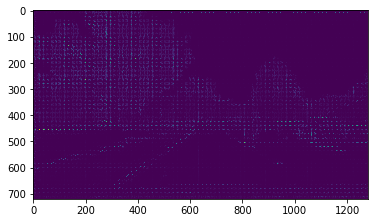

In [24]:
show_hog_vis(image)

Below we perform calculations on the number and size of the windows based on the scaling and size of the image patch. We then extract HOG features once on the image patch. Finally, we extract spatial, color, and a sub-sampling of the HOG features for the search window before making our prediction. The bounding boxes of all positive predictions are returned.

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=False):    
    draw_img = np.copy(img)
    bbox_list = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_corner = (xbox_left, ytop_draw + ystart)
                bottom_corner = (xbox_left + win_draw,ytop_draw + win_draw+ystart)
                bbox_list.append([top_corner, bottom_corner])
                cv2.rectangle(draw_img, top_corner, bottom_corner, (0,0,255), 6) 
            
    if vis: 
        return draw_img, bbox_list
    else:
        return bbox_list
    


We can visualize the predicted bounding boxes here for the `y=(400,600)` image patch at `scale=1.5`.

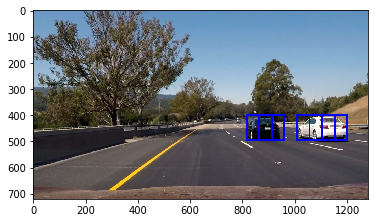

In [35]:
out_img, bbox_list = find_cars(image, 400, 600, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, vis=True)

plt.imshow(out_img)

## Heatmap False Positive Detection

We can produce a heatmap of the boxes found by adding up the areas of each overlapping box, with any highly overlapped area showing greater intensity. We can then apply some thresholding to the heatmap to exclude boxes under a certain intensity threshold. This allows us to detect and remove false positives.

In [10]:
def add_heat(heatmap, tracked_bboxes):
    # Iterate through previous frames
    for bbox_list in tracked_bboxes:
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
            
    # Return the labeled image
    return img

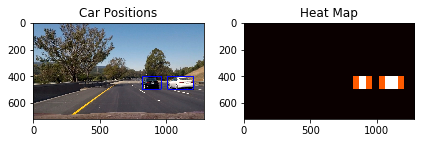

In [11]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, [bbox_list])
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Final Pipeline

In our final pipeline, we keep track of cars found in previous frames and add them to our heatmap. 

In [15]:
# Re-initialize tracking
tracked_bboxes = []

def pipeline(image):
    scales = [((400, 600), 1),
              ((400, 600), 1.5)]
    scaled_bbox_list = []
    
    # Find cars for each scale within their corresponding window
    for scale in scales:
        window = scale[0]
        scaled_bbox_list += find_cars(image, window[0], window[1], scale[1], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Track this frame's found bounding boxes
    global tracked_bboxes
    tracked_bboxes.append(scaled_bbox_list)
    
    # Remove the oldest frame
    if len(tracked_bboxes) > frame_count:
        tracked_bboxes = tracked_bboxes[1:]
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, tracked_bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 15)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(np.copy(image), labels)

## Process Video

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [08:20<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 7min 23s, sys: 48.6 s, total: 8min 12s
Wall time: 8min 22s
